# Лабораторная №2: Алгоритм Дойча

## Задача
Есть неизвестная функция $f:\{0,1\}\to\{0,1\}$. Гарантируется, что она либо **конст** $\big(f(0)=f(1)\big)$, либо **баланс** $\big(f(0)\ne f(1)\big)$. Нужно отличить эти два типа одним вызовом оракула $U_f$.

## Схема
$$
\lvert 0\rangle \lvert 1\rangle 
\;\xrightarrow{\,H\otimes H\,}\; 
U_f 
\;\xrightarrow{\;H\ \text{ на } q_0\;}\; 
\text{измерить } q_0
$$

Интерпретация результата:
- $q_0=0 \Rightarrow \text{const}$
- $q_0=1 \Rightarrow \text{balanced}$

## Математика
1) Старт:
$$
\lvert 0\rangle\lvert 1\rangle.
$$

2) После $H\otimes H$:
$$
\frac{\lvert 0\rangle+\lvert 1\rangle}{\sqrt{2}}
\;\otimes\;
\frac{\lvert 0\rangle-\lvert 1\rangle}{\sqrt{2}}.
$$

3) Оракул $U_f$ действует как $\lvert x,y\rangle \mapsto \lvert x,\, y \oplus f(x)\rangle$.
На втором кубите, подготовленном в $\big(\lvert 0\rangle-\lvert 1\rangle\big)/\sqrt{2}$, это эквивалентно фазовой метке $(-1)^{f(x)}$ у компоненты $\lvert x\rangle$:
$$
\frac{1}{2}\sum_{x\in\{0,1\}}
\Big[\,(-1)^{f(x)}\, \lvert x\rangle \otimes (\lvert 0\rangle-\lvert 1\rangle)\,\Big].
$$

4) Финальный $H$ на $q_0$ переводит разницу фаз в вычислительный базис:
- если $f$ константна, фазы равны $\Rightarrow$ усиливается $\lvert 0\rangle$ $\Rightarrow$ детерминированно получаем $0$;
- если $f$ балансна, фазы противоположны $\Rightarrow$ усиливается $\lvert 1\rangle$ $\Rightarrow$ детерминированно получаем $1$.



In [14]:
from __future__ import annotations

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from collections import Counter

def oracle_f00(): # Тождественная
    oc = QuantumCircuit(2, name="U_f: f00_const0")
    # |x>|y> -> |x>|y (X) 0> = |x>|y> (I)
    return oc

def oracle_f11(): # Константная (1)
    oc = QuantumCircuit(2, name="U_f: f11_const1")
    oc.x(1) # flip q1 |x>|y> -> |x>|y (X) 1>  ---- Х 
    return oc

def oracle_f01(): # сбалансированная: 0 1
    oc = QuantumCircuit(2, name="U_f: f01_balanced")
    # Control not: |x>|y> -> |x>|y (X) x> --- CX
    oc.cx(0, 1)
    return oc

def oracle_f10(): # сбалансированная: 1 0
    oc = QuantumCircuit(2, name="U_f: f10_balanced")
    # инвертированный контроль: flip q0 если x=0 
    oc.x(0); oc.cx(0, 1); oc.x(0)
    return oc

ORACLES = {
    "f00_const0": oracle_f00,
    "f11_const1": oracle_f11,
    "f01_balanced": oracle_f01,
    "f10_balanced": oracle_f10
}

def build_circuit(oracle_builder):
    # U_f подцепочка как единый блок
    Uf = oracle_builder().to_instruction() 
    # 2 кубита и 1 классический бит
    qc = QuantumCircuit(2, 1)

    # Подготовка |0>|1> -> X на вспомогательном кубите q1
    # из |1> получаем |-> для возврата фазы -> уже не нужен
    qc.x(1)

    # |+> на q0 и |−> на q1
    qc.h(0) # |0> -> |+>
    qc.h(1) # |1> -> |->
    # фаза (-1)^f(x)

    # Uf - q0 && Uf - q1 
    qc.append(Uf, [0, 1])

    # H вернет в глобальную 0 || 1 
    qc.h(0) 

    # q0 + 0 c[0]
    qc.measure(0, 0)
    return qc

# P(q=N) - вектор состояний
def build_state_prep(oracle_builder):
    Uf = oracle_builder().to_instruction()
    qc = QuantumCircuit(2)
    qc.x(1); qc.h(0); qc.h(1)  # NOT(q1) -> состояние |1> -> H(0) H(1) => q1=|->, q0 = |+>
    # => q0 (X) q1  = 1/2(00 - 01 + 10 + 11) 
    qc.append(Uf, [0, 1]) # Uf -> q0, Uf -> q1
    qc.h(0) # => Uf = (|x> |->) = (-1)^f(x) |x> |->
    # вся информация о f уходит в фазы компонент по x у q0
    return qc

def probs_q0_from_state(oracle_builder):
    # P(q0=0/1)
    # Уже в суперпозиции phi = 1/2(00 - 01 + 11 - 10 = |->q0 (X) |->q1)
    # Измерение M

    
    # a00|00> + a01|01> + a10|10| + a11|11> (a-амплитуды)
    sv = Statevector.from_instruction(build_state_prep(oracle_builder))
    amp = sv.data # [0] = a00, [1] = a01 ...
    p0 = float(np.sum(np.abs(amp[0::2])**2))  # сумма квадратов модулей 
    p1 = 1.0 - p0 
    return p0, p1

def oracle_choise(p0, p1, tol=1e-10):
    if p0 > 1 - tol:
        return "константная"
    if p1 > 1 - tol:
        return "сбалансированная"
    return "ошибка"

def sample_counts(oracle_key="f00_const0", shots=1000, seed=None):
    oracle_builder = ORACLES[oracle_key]
    qc = build_circuit(oracle_builder)

    p0, p1 = probs_q0_from_state(oracle_builder)
    rng = np.random.default_rng(seed)
    samples = rng.choice(['0', '1'], p=[p0, p1], size=shots)
    return Counter(samples)

def run_all():
    for name, ob in ORACLES.items():
        print("Оракл:", name)

        qc = build_circuit(ob)
        print("\n Схема ")
        print(qc.draw(output="text", idle_wires=False, fold=-1))

        print("\n разложенная на базовые гейты")
        print(qc.remove_final_measurements(inplace=False).decompose(reps=10).draw(
            output="text", idle_wires=False, fold=-1
        ))

        p0, p1 = probs_q0_from_state(ob)
        print(f"\nP(q0=0)={p0:.6f}  P(q0=1)={p1:.6f}")
        print("Выбрал:", oracle_choise(p0, p1))

if __name__ == "__main__":
    run_all()

    print("\n --------------------------------")
    for key in ORACLES:
        counts = sample_counts(key, shots=1000, seed=42)
        print(f"{key}: {dict(counts)}")

Оракл: f00_const0

 Схема 
     ┌───┐     ┌──────────────────┐┌───┐┌─┐
q_0: ┤ H ├─────┤0                 ├┤ H ├┤M├
     ├───┤┌───┐│  U_f: f00_const0 │└───┘└╥┘
q_1: ┤ X ├┤ H ├┤1                 ├──────╫─
     └───┘└───┘└──────────────────┘      ║ 
c: 1/════════════════════════════════════╩═
                                         0 

 разложенная на базовые гейты
     ┌────────────┐┌────────────┐
q_0: ┤ U(π/2,0,π) ├┤ U(π/2,0,π) ├
     └┬──────────┬┘├────────────┤
q_1: ─┤ U(π,0,π) ├─┤ U(π/2,0,π) ├
      └──────────┘ └────────────┘

P(q0=0)=1.000000  P(q0=1)=0.000000
Выбрал: константная
Оракл: f11_const1

 Схема 
     ┌───┐     ┌──────────────────┐┌───┐┌─┐
q_0: ┤ H ├─────┤0                 ├┤ H ├┤M├
     ├───┤┌───┐│  U_f: f11_const1 │└───┘└╥┘
q_1: ┤ X ├┤ H ├┤1                 ├──────╫─
     └───┘└───┘└──────────────────┘      ║ 
c: 1/════════════════════════════════════╩═
                                         0 

 разложенная на базовые гейты
     ┌────────────┐┌────────────┐         

# Лабораторная №3: Алгоритм Дойча-Йожи
```txt
Йожин с бажин
```

Тот же алгоритм, что и Дойча, но функция 
$$ f: \{0 ,1 \}^n \rightarrow \{ 0, 1\}$$

На входе $ n $ кубитов 

$$
\lvert 0...0\rangle \lvert 1\rangle 
\;\xrightarrow{\,H\otimes H\,}\; 
U_f 
\;\xrightarrow{\;H\ \text{ на } q_0\;}\; 
\text{измерить } q_0
$$

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np
from collections import Counter

def oracle_const0(n):  # f(x)=0
    oc = QuantumCircuit(n+1, name=f"U_f: f00_const0_n{n}")
    return oc

def oracle_const1(n):  # f(x)=1
    oc = QuantumCircuit(n+1, name=f"U_f: f11_const1_n{n}")
    oc.x(n)  # flip 
    return oc

def oracle_balanced_x0(n):  # f(x)=x0
    oc = QuantumCircuit(n+1, name=f"U_f: f01_balanced_x0_n{n}")
    oc.cx(0, n)
    return oc

def oracle_balanced_parity(n):  # f(x)=x0(+)x1(+)...(+)x_{n-1}
    oc = QuantumCircuit(n+1, name=f"U_f: f10_balanced_parity_n{n}")
    for i in range(n):
        oc.cx(i, n)
    return oc

ORACLES = {
    "f00_const0": oracle_const0,
    "f11_const1": oracle_const1,
    "f01_balanced_x0": oracle_balanced_x0,
    "f10_balanced_parity": oracle_balanced_parity,
}

def build_circuit_DJ(oracle_builder, n):
    Uf = oracle_builder(n).to_instruction()
    qc = QuantumCircuit(n+1, n)  # n входных, 1 n классических

    # |0...0>|1>
    qc.x(n)

    # |+>^n |-> 
    for i in range(n): qc.h(i)
    qc.h(n)

    # U_f : (-1)^{f(x)} на |x>
    qc.append(Uf, list(range(n+1)))

    # H^n на входном регистре
    for i in range(n): qc.h(i)

    # измеряем только входной регистр
    for i in range(n): qc.measure(i, i)
    return qc

# вектор состояний
def build_state_prep_DJ(oracle_builder, n):
    Uf = oracle_builder(n).to_instruction()
    qc = QuantumCircuit(n+1)
    qc.x(n)
    for i in range(n): qc.h(i)
    qc.h(n)
    qc.append(Uf, list(range(n+1)))
    for i in range(n): qc.h(i)
    return qc

def probs_first_register(oracle_builder, n):
    sv = Statevector.from_instruction(build_state_prep_DJ(oracle_builder, n))
    amp = sv.data
    base = 1 << n  # шаг по старшему биту 
    probs = np.zeros(1 << n, dtype=float)
    # p[x] = |amp[x]|^2 + |amp[x + 2^n]|^2 
    for x in range(1 << n):
        probs[x] = float(np.abs(amp[x])**2 + np.abs(amp[x + base])**2)
    return probs

def classify_DJ(probs, tol=1e-10):
    if probs[0] > 1 - tol: return "константная"
    if probs[0] < tol:     return "сбалансированная"
    return "неидеально/шум"

def sample_counts_DJ(oracle_key="f00_const0", n=3, shots=1000, seed=None):
    oracle_builder = ORACLES[oracle_key]
    probs = probs_first_register(oracle_builder, n)
    bitstrings = [format(k, f"0{n}b") for k in range(1 << n)]
    rng = np.random.default_rng(seed)
    samples = rng.choice(bitstrings, p=probs, size=shots)
    return Counter(samples)

def run_all_DJ(n=3):
    for name, ob in ORACLES.items():
        print("Оракул:", name, f"(n={n})")

        qc = build_circuit_DJ(ob, n)
        print("\n Схема ")
        print(qc.draw(output="text", idle_wires=False, fold=-1))

        print("\n разложенная на базовые гейты (вся схема без измерений)")
        print(qc.remove_final_measurements(inplace=False).decompose(reps=10).draw(
            output="text", idle_wires=False, fold=-1
        ))

        Uf = ob(n)
        print("\n Декомпозиция оракула U_f")
        print(Uf.decompose(reps=10).draw(output="text", idle_wires=False, fold=-1))

        pr = probs_first_register(ob, n)
        p_zero = pr[0]
        print(f"\nP(first register = {'0'*n}) = {p_zero:.6f}")
        if n == 1:
            print(f"P(q0=0)={pr[0]:.6f}  P(q0=1)={pr[1]:.6f}")
        print("Выбрал:", classify_DJ(pr))
        print("-"*64)

if __name__ == "__main__":
    run_all_DJ(n=3)


Оракул: f00_const0 (n=3)

 Схема 
     ┌───┐     ┌─────────────────────┐┌───┐┌─┐      
q_0: ┤ H ├─────┤0                    ├┤ H ├┤M├──────
     ├───┤     │                     │├───┤└╥┘┌─┐   
q_1: ┤ H ├─────┤1                    ├┤ H ├─╫─┤M├───
     ├───┤     │  U_f: f00_const0_n3 │├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─────┤2                    ├┤ H ├─╫──╫─┤M├
     ├───┤┌───┐│                     │└───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├┤3                    ├──────╫──╫──╫─
     └───┘└───┘└─────────────────────┘      ║  ║  ║ 
c: 3/═══════════════════════════════════════╩══╩══╩═
                                            0  1  2 

 разложенная на базовые гейты (вся схема без измерений)
     ┌────────────┐┌────────────┐
q_0: ┤ U(π/2,0,π) ├┤ U(π/2,0,π) ├
     ├────────────┤├────────────┤
q_1: ┤ U(π/2,0,π) ├┤ U(π/2,0,π) ├
     ├────────────┤├────────────┤
q_2: ┤ U(π/2,0,π) ├┤ U(π/2,0,π) ├
     └┬──────────┬┘├────────────┤
q_3: ─┤ U(π,0,π) ├─┤ U(π/2,0,π) ├
      └──────────┘ └────────────┘

 Декомпозиция ораку

# Лабораторная работа №4:
- ### 4.1: Алгоритм Бернштейна-Вазирани,
- ### 4.2: Алгоритм Саймона.

$$ f\colon \{0,1\}^n \to \{0,1\} $$

### Берншейна-Вазирани : 
$ f(x) = a \cdot x = a_0 x_0 \oplus a_1 x_1 \oplus \dots \oplus a_{n-1} x_{n-1} $

Оракул $ U_f $ реализуется как набор CNOT от тех входов где $ a_i = 1 $ к целевому кубиту

### Саймона :
$$ f\colon \{0,1\}^n \to \{0,1\}^n $$
Использует на входе $\ket{0}^n$ и $\ket{0}^n$ кубит. 
По измерениям кубит, строятся $2n-1$ СЛНУ, где ищем компоненту $a$. 

In [32]:
import numpy as np
import cirq
import random

class BV(object):

  def __init__(self, bitstring_length=8, repetitions=10):
    self.repetitions = repetitions
    self.num_qubits = bitstring_length + 1
    # кубиты 
    self.input_qubits = [cirq.GridQubit(i, 0) for i in range(self.num_qubits)]
    self.output_qubit = cirq.GridQubit(self.num_qubits, 0)

  def make_oracle(self, input_qubits, output_qubit,
                  secret_bitstring=None, secret_bias_bit=None):
    if secret_bias_bit:
        yield cirq.X(self.output_qubit)
    for qubit, bit in zip(self.input_qubits, secret_bitstring):
        if bit:
            yield cirq.CNOT(qubit, self.output_qubit)

  def make_bernstein_vazirani_circuit(self, input_qubits, output_qubit, oracle):
      c = cirq.Circuit()
      # инициализация
      c.append([cirq.X(output_qubit), cirq.H(output_qubit), cirq.H.on_each(*input_qubits)])
      # вызов оракула
      c.append(oracle)
      # измерение в X базисе
      c.append([cirq.H.on_each(*input_qubits), cirq.measure(*input_qubits, key='result')])
      return c

  def run_bernstein_vazirani_simulation(self, secret_bitstring=None, secret_bias_bit=None):
    if not secret_bias_bit:
      secret_bias_bit = random.randint(0, 1)
    if not secret_bitstring:
      secret_bitstring = [random.randint(0, 1)
                          for _ in range(self.num_qubits)]
    oracle = self.make_oracle(self.input_qubits, self.output_qubit,
                              secret_bitstring, secret_bias_bit)
    circuit = self.make_bernstein_vazirani_circuit(self.input_qubits,
                                                   self.output_qubit, oracle)
    print('Схема:')
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=self.repetitions)
    frequencies = result.histogram(key='result', fold_func=bitstring)
    print('Результат:')
    print(f"Targeted secret string: {''.join(map(str, secret_bitstring))}")
    for k, v in frequencies.items():
      print(f"Measured secret string: {k}", "||", v*100/self.repetitions)


def bitstring(bits):
    return ''.join(str(int(b)) for b in bits)

dsim = BV(bitstring_length=5)
dsim.run_bernstein_vazirani_simulation()



Схема:
(0, 0): ───H───H───────────────────M('result')───
                                   │
(1, 0): ───H───H───────────────────M─────────────
                                   │
(2, 0): ───H───────────@───H───────M─────────────
                       │           │
(3, 0): ───H───────────┼───@───H───M─────────────
                       │   │       │
(4, 0): ───H───H───────┼───┼───────M─────────────
                       │   │       │
(5, 0): ───H───H───────┼───┼───────M─────────────
                       │   │
(6, 0): ───X───H───X───X───X─────────────────────
Результат:
Targeted secret string: 001100
Measured secret string: 001100 || 100.0


In [ ]:
# Алгоритм Саймона

from __future__ import annotations

from collections import Counter

import numpy as np
import scipy as sp

import cirq


def main(qubit_count=3):

    data = []  # здесь будем хранить результаты

    secret_string = np.random.randint(2, size=qubit_count)

    print(f'строка = {secret_string}')

    n_samples = 100
    for _ in range(n_samples):
        flag = False  # проверяем, есть ли у нас линейно независимый набор измерений
        while not flag:
            # Выбираем кубиты для использования.
            input_qubits = [cirq.GridQubit(i, 0) for i in range(qubit_count)]  # вход x
            output_qubits = [
                cirq.GridQubit(i + qubit_count, 0) for i in range(qubit_count)
            ]  # выход f(x)

            # Выбираем коэффициенты для оракула и создаем схему для запроса к нему.
            oracle = make_oracle(input_qubits, output_qubits, secret_string)

            # Встраиваем оракул в специальную квантовую схему, запрашивая его ровно один раз
            circuit = make_simon_circuit(input_qubits, output_qubits, oracle)

            # Выполняем схему n-1 раз (n = qubit_count).
            simulator = cirq.Simulator()
            results = [
                simulator.run(circuit).measurements['result'][0] for _ in range(qubit_count - 1)
            ]

            # Классическая пост-обработка:
            flag = post_processing(data, results)

    # Частота появления различных данных для строки  + при каждом запуске разные значения
    freqs = Counter(data)
    print('Схема:')
    print(circuit)
    print(f': {freqs.most_common(1)[0]}')


def make_oracle(input_qubits, output_qubits, secret_string):
    """Гейты, реализующие функцию f(a) = f(b) тогда и только тогда, когда a XOR b = s"""
    # Копируем содержимое на выходные кубиты:
    for control_qubit, target_qubit in zip(input_qubits, output_qubits):
        yield cirq.CNOT(control_qubit, target_qubit)

    # Создаем отображение:
    if sum(secret_string):  # проверяем, не является ли секретная строка нулевой
        # Находим значимый бит секретной строки (первый ненулевой бит)
        significant = list(secret_string).index(1)

        # Добавляем секретную строку ко входу в соответствии со значимым битом:
        for j in range(len(secret_string)):
            if secret_string[j] > 0:
                yield cirq.CNOT(input_qubits[significant], output_qubits[j])
    # Применяем случайную перестановку:
    pos = [
        0,
        len(secret_string) - 1,
    ]  # Меняем местами некоторые кубиты для определения оракула. Выбираем первый и последний:
    yield cirq.SWAP(output_qubits[pos[0]], output_qubits[pos[1]])


def make_simon_circuit(input_qubits, output_qubits, oracle):
    """Решает задачу нахождения периода s функции такой, что
    f(x) = f(y) тогда и только тогда, когда x XOR y = s
    """

    c = cirq.Circuit()

    # Инициализируем кубиты.
    c.append([cirq.H.on_each(*input_qubits)])

    # Запрашиваем оракул
    c.append(oracle)

    # Измеряем в X базисе
    c.append([cirq.H.on_each(*input_qubits), cirq.measure(*input_qubits, key='result')])

    return c


def post_processing(data, results):
    """Решает систему уравнений с числами по модулю 2"""
    sing_values = sp.linalg.svdvals(results)
    tolerance = 1e-5
    if sum(sing_values < tolerance) == 0:  # проверяем, являются ли измерения линейно независимыми
        flag = True
        null_space = sp.linalg.null_space(results).T[0]
        solution = np.around(null_space, 3) 
        minval = abs(min(solution[np.nonzero(solution)], key=abs))
        solution = (solution / minval % 2).astype(int)  # перенормируем вектор по модулю 2
        data.append(str(solution))
        return flag

if __name__ == '__main__':
    main()

строка = [0 0 1]
Схема:
               ┌───┐
(0, 0): ───H────@──────H───────M('result')───
                │              │
(1, 0): ───H────┼@─────H───────M─────────────
                ││             │
(2, 0): ───H────┼┼@────@───H───M─────────────
                │││    │
(3, 0): ────────X┼┼────┼───×─────────────────
                 ││    │   │
(4, 0): ─────────X┼────┼───┼─────────────────
                  │    │   │
(5, 0): ──────────X────X───×─────────────────
               └───┘
: ('[0 0 1]', 100)


# Лабораторная работа №5 : Протокол BB84

- Теорема о запрете клонирования
Есть ли такое $U$ (унитарное преобразование), что склонирует из одного квантового состояния $\ket{\psi}$ в два одинаковых ему $\ket{\psi}\ket{\psi}$
$$ \ket{\psi} = \ket{\psi}\ket{\psi} $$
$$ \ket{\psi} = C_1 \ket{0} + C_2 \ket{1} $$
$$K(C_1\ket{0} + C_2\ket{1}) = (C_1\ket{0} + C_2\ket{1}) \otimes (C_1\ket{0} + C_2\ket{1}) = C_1^2\ket{00} + C_1C_2\ket{01} + C_2C_1\ket{10} + C_2^2\ket{11}$$
$$K(C_1\ket{0} + C_2\ket{1}) = C_1 K\ket{0} + C_2 K\ket{1} = C_1 \ket{00} + C_2 \ket{11}$$

$$ \Rightarrow \nexists \texttt{  } U \texttt{  которое могло бы создать два кубита с одинаковами состояниями}$$

- Эксперемент Штерна-Герлаха
<p align="center">
  <img src="img/experiment.png" alt="Эксперимент Штерна-Герлаха">
</p>

<p align="center">
  <img src="img/SG-E.png" alt="Схема Э.Ш-Г">
</p>



In [ ]:
from src_lab_5.interface import QuantumDevice, Qubit
from src_lab_5.simulator import SingleQubitSimulator
from typing import List

def sample_random_bit(device: QuantumDevice) -> bool: 
    with device.using_qubit() as q:
        q.h()
        result = q.measure()
        q.reset()
    return result 

def prepare_message_qubit(message: bool, basis: bool, q: Qubit) -> None:
    if message:
        q.x()
    if basis:
        q.h()

def measure_message_qubit(basis: bool, q: Qubit) -> bool:
    if basis:
        q.h()
    result = q.measure()
    q.reset()
    return result

def convert_to_hex(bits: List[bool]) -> str:
    return hex(int("".join(["1" if bit else "0" for bit in bits]),2))

def send_single_bit_with_bb84(your_device: QuantumDevice, eve_device: QuantumDevice) -> tuple:

    [your_message, your_basis] = [
        sample_random_bit(your_device) for _ in range(2)
    ]

    eve_basis = sample_random_bit(eve_device)

    with your_device.using_qubit() as q:
        prepare_message_qubit(your_message, your_basis, q)

        # Посылаем кубиты

        eve_result = measure_message_qubit(eve_basis, q)

    return ((your_message, your_basis), (eve_result, eve_basis))

def simulate_bb84(n_bits: int) -> list:
    your_device = SingleQubitSimulator()
    eve_device = SingleQubitSimulator()

    key = []
    n_rounds = 0

    while len(key) < n_bits:
        n_rounds += 1
        ((your_message, your_basis), (eve_result, eve_basis)) = send_single_bit_with_bb84(your_device, eve_device)

        if your_basis == eve_basis:
            assert your_message == eve_result
            key.append(your_message)

    print(f"Took {n_rounds} rounds to generate a {n_bits}-bit key.")

    return key

def apply_one_time_pad(message: List[bool], key: List[bool]) -> List[bool]:
    return [
        message_bit ^ key_bit
        for (message_bit, key_bit) in zip(message, key)
    ]

if __name__ == "__main__":
    print("Generating a 96-bit key by simulating BB84...")
    key = simulate_bb84(96)
    print(f"Got key                           {convert_to_hex(key)}.")

    message = [
        1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 0, 1, 1
    ]
    print(f"Using key to send secret message: {convert_to_hex(message)}.")

    encrypted_message = apply_one_time_pad(message, key)
    print(f"Encrypted message:                {convert_to_hex(encrypted_message)}.")
    decrypted_message = apply_one_time_pad(encrypted_message, key)
    print(f"Eve decrypted to get:             {convert_to_hex(decrypted_message)}.")
    

Generating a 96-bit key by simulating BB84...
Took 193 rounds to generate a 96-bit key.
Got key                           0x3882702d358db0510077a3a7.
Using key to send secret message: 0xd83ddc96d83ddc2dd83ddcbb.
Encrypted message:                0xe0bfacbbedb06c7cd84a7f1c.
Eve decrypted to get:             0xd83ddc96d83ddc2dd83ddcbb.


# Лабораторная работа №6: Состояния Белла и Квантовая телепортация

## 4 состояния Белла:

$$
    \mathbb{P} = \alpha_1\alpha_2 \ket{00} + \alpha_1\beta_2 \ket{01} + \beta_2\alpha_2 \ket{10} + \beta_1\beta_2 \ket{11}
$$

$$ 
    \ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}
    \\
    \ket{\Phi^-} = \frac{\ket{01} + \ket{10}}{\sqrt{2}}
    \\
    \ket{\Psi^+} = \frac{\ket{01} + \ket{10}}{\sqrt{2}}
    \\
    \ket{\Psi^-} = \frac{\ket{01} + \ket{10}}{\sqrt{2}}
    \\
    \Rightarrow \texttt{   } (\Phi^+, \Phi^-, \Psi^+, \Psi^-)
$$

In [ ]:
"""
1) задаем случайные X,Y для кубита 0 делая его состояние
2) применяем адамара к 1 и CNOT на 1 и 2 Кубит для запутанности 
3) применяем CNOT с 1 на 0 и адамара на 0 
4) измеряем Кубит 0 (msg) при 1 применяем  Z к кубиту 2 
5) измеряем Кубит 1 (Alice) при 1 применяем  X к кубиту 2 
6) получили состояние с 1)

В коде: F+ = |00> + |11> / sqrt(2)


F- :
Вместо H(1) + CNOT(1,2)
cirq.H(1)
cirq.CNOT(1, 2)
cirq.Z(1)  # Добавляем Z-гейт
Корр:
(msg, alice) = (0,0) → Z
(msg, alice) = (0,1) → XZ
(msg, alice) = (1,0) → I (ничего)
(msg, alice) = (1,1) → X

Psi+ 
# Вместо H(1) + CNOT(1,2)  
cirq.H(1)
cirq.CNOT(1, 2)
cirq.X(2)  # Добавляем X-гейт
Корр:
(msg, alice) = (0,0) → X
(msg, alice) = (0,1) → I (ничего)
(msg, alice) = (1,0) → XZ
(msg, alice) = (1,1) → Z

Psi - 
cirq.H(1)
cirq.CNOT(1, 2)
cirq.X(2)
cirq.Z(1)  # Комбинация X и Z
Корр:
(msg, alice) = (0,0) → XZ
(msg, alice) = (0,1) → Z
(msg, alice) = (1,0) → X
(msg, alice) = (1,1) → I (ничего)
"""

from __future__ import annotations

import random

import numpy as np

import cirq

def make_quantum_teleportation_circuit(ranX, ranY):
    circuit = cirq.Circuit()
    msg, alice, bob = cirq.LineQubit.range(3)

    # Creates Bell state to be shared between Alice and Bob.
    circuit.append([cirq.H(alice), cirq.CNOT(alice, bob)])
    # Creates a random state for the Message.
    circuit.append([cirq.X(msg) ** ranX, cirq.Y(msg) ** ranY])
    # Bell measurement of the Message and Alice's entangled qubit.
    circuit.append([cirq.CNOT(msg, alice), cirq.H(msg)])
    circuit.append(cirq.measure(msg, key='msg'))
    circuit.append(cirq.measure(alice, key='alice'))
    # Uses the two classical bits from the Bell measurement to recover the
    # original quantum Message on Bob's entangled qubit.
    circuit.append(cirq.X(bob).with_classical_controls('alice'))
    circuit.append(cirq.Z(bob).with_classical_controls('msg'))

    return circuit


def main(seed=None):
    """Run a simple simulation of quantum teleportation.

    Args:
        seed: The seed to use for the simulation.
    """
    random.seed(seed)

    ranX = random.random()
    ranY = random.random()
    circuit = make_quantum_teleportation_circuit(ranX, ranY)

    print("Circuit:")
    print(circuit)

    sim = cirq.Simulator(seed=seed)

    # Run a simple simulation that applies the random X and Y gates that
    # create our message.
    q0 = cirq.LineQubit(0)
    message = sim.simulate(cirq.Circuit([cirq.X(q0) ** ranX, cirq.Y(q0) ** ranY]))

    print("\nBloch Sphere of Message After Random X and Y Gates:")
    # Prints the Bloch Sphere of the Message after the X and Y gates.
    expected = cirq.bloch_vector_from_state_vector(message.final_state_vector, 0)
    print(
        "x: ",
        np.around(expected[0], 4),
        "y: ",
        np.around(expected[1], 4),
        "z: ",
        np.around(expected[2], 4),
    )

    # Records the final state of the simulation.
    final_results = sim.simulate(circuit)

    print("\nBloch Sphere of Qubit 2 at Final State:")
    # Prints the Bloch Sphere of Bob's entangled qubit at the final state.
    teleported = cirq.bloch_vector_from_state_vector(final_results.final_state_vector, 2)
    print(
        "x: ",
        np.around(teleported[0], 4),
        "y: ",
        np.around(teleported[1], 4),
        "z: ",
        np.around(teleported[2], 4),
    )

    return expected, teleported


if __name__ == '__main__':
    main()

Circuit:
                                      ┌──┐
0: ───────X^0.586───Y^(8/9)───@───H────M─────────
                              │        ║
1: ───────H─────────@─────────X───M────╫─────────
                    │             ║    ║
2: ─────────────────X─────────────╫────╫X────Z───
                                  ║    ║║    ║
alice: ═══════════════════════════@════╬^════╬═══
                                       ║     ║
msg: ══════════════════════════════════@═════^═══
                                      └──┘

Bloch Sphere of Message After Random X and Y Gates:
x:  -0.0916 y:  -0.9638 z:  0.2504

Bloch Sphere of Qubit 2 at Final State:
x:  -0.0916 y:  -0.9638 z:  0.2504


# Лабораторная работа №7: 
# Алгоритм оценки фазы

In [ ]:
from __future__ import annotations

import numpy as np
import cirq


def run_estimate(unknown_gate, qnum, repetitions):
    ancilla = cirq.LineQubit(-1) # Вспомогательный
    qubits = cirq.LineQubit.range(qnum) # Для оценки фазы

    # Управление-Контроль U^2i
    oracle_raised_to_power = [
        unknown_gate.on(ancilla).controlled_by(qubits[i]) ** (2**i) for i in range(qnum)
    ]
    circuit = cirq.Circuit(
        cirq.H.on_each(*qubits), # H на весь регистр
        oracle_raised_to_power, # U^(2^i), i - индекс кубита
        cirq.qft(*qubits, without_reverse=True) ** -1, # Обожаю это преобразование как его там... KFC?
        cirq.measure(*qubits, key='phase'), # фаза
    )

    return cirq.sample(circuit, repetitions=repetitions)


def experiment(qnum, repetitions=100):

    def example_gate(phi):
        # Матрица (e 0, 0 1) => получается собственный вектор |0> с собственным e^ipiphi и вектор |1> собственным 1
        gate = cirq.MatrixGate(matrix=np.array([[np.exp(2 * np.pi * 1.0j * phi), 0], [0, 1]]))
        return gate

    print(f'Testing with {qnum} qubits.')
    errors = []
    for target in np.arange(0, 1, 0.1): # 0 .. 0.9 
        result = run_estimate(example_gate(target), qnum, repetitions)
        mode = result.data['phase'].mode()[0] # самое частое
        guess = mode / 2**qnum # из битов -> фаза
        print(f'target={target:0.4f}, estimate={guess:0.4f}={mode}/{2**qnum}') 
        errors.append((target - guess) ** 2) # средняя квадратичная ошибка
    rms = np.sqrt(sum(errors) / len(errors))
    print(f'RMS Error: {rms:0.4f}\n')


def main(qnums=(2, 4), repetitions=100): 
    for qnum in qnums:
        experiment(qnum, repetitions=repetitions)
# N(bit_string) / 2^n 

if __name__ == '__main__':
    main()

Testing with 2 qubits.
target=0.0000, estimate=0.0000=0/4
target=0.1000, estimate=0.0000=0/4
target=0.2000, estimate=0.2500=1/4
target=0.3000, estimate=0.2500=1/4
target=0.4000, estimate=0.5000=2/4
target=0.5000, estimate=0.5000=2/4
target=0.6000, estimate=0.5000=2/4
target=0.7000, estimate=0.7500=3/4
target=0.8000, estimate=0.7500=3/4
target=0.9000, estimate=0.0000=0/4
RMS Error: 0.2915

Testing with 4 qubits.
target=0.0000, estimate=0.0000=0/16
target=0.1000, estimate=0.1250=2/16
target=0.2000, estimate=0.1875=3/16
target=0.3000, estimate=0.3125=5/16
target=0.4000, estimate=0.3750=6/16
target=0.5000, estimate=0.5000=8/16
target=0.6000, estimate=0.6250=10/16
target=0.7000, estimate=0.6875=11/16
target=0.8000, estimate=0.8125=13/16
target=0.9000, estimate=0.8750=14/16
RMS Error: 0.0177



# QFT

In [19]:
from __future__ import annotations

import numpy as np

import cirq


def main():
    qft_circuit = generate_2x2_grid_qft_circuit()
    print('Circuit:')
    print(qft_circuit)
    simulator = cirq.Simulator()
    result = simulator.simulate(qft_circuit)
    print()
    print('FinalState')
    print(np.around(result.final_state_vector, 3))

# То есть матрица diag(1,1,1,e^ipiROT)
# Применяет фазу только к |11>
# делает своп и значения 0,5: 0,25: 0,125 : 90, 45, 22.5
def _cz_and_swap(q0, q1, rot): # Основное контроль вращения и обмена
    yield cirq.CZ(q0, q1) ** rot # Control Z -> Rot
    yield cirq.SWAP(q0, q1) # swap 

def generate_2x2_grid_qft_circuit():
    a, b, c, d = [  # инициализация как 2Д решетка 
        cirq.GridQubit(0, 0),
        cirq.GridQubit(0, 1),
        cirq.GridQubit(1, 1),
        cirq.GridQubit(1, 0),
    ]

    circuit = cirq.Circuit(
        cirq.H(a),
        _cz_and_swap(a, b, 0.5), 
        _cz_and_swap(b, c, 0.25),
        _cz_and_swap(c, d, 0.125),
        cirq.H(a), # тащим по всей решетке 
        _cz_and_swap(a, b, 0.5),
        _cz_and_swap(b, c, 0.25),
        cirq.H(a),
        _cz_and_swap(a, b, 0.5),
        cirq.H(a),
        strategy=cirq.InsertStrategy.EARLIEST,
    )
    return circuit


if __name__ == '__main__':
    main()

Circuit:
(0, 0): ───H───@───────×───H────────────@─────────×───H────────────@───────×───H───
               │       │                │         │                │       │
(0, 1): ───────@^0.5───×───@────────×───@^0.5─────×───@────────×───@^0.5───×───────
                           │        │                 │        │
(1, 0): ───────────────────┼────────┼───@─────────×───┼────────┼───────────────────
                           │        │   │         │   │        │
(1, 1): ───────────────────@^0.25───×───@^(1/8)───×───@^0.25───×───────────────────

FinalState
[0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j
 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j 0.25+0.j]


# Алгоритм Китаева

In [3]:
import cirq
import numpy as np
from math import acos, pi, sqrt, cos

def naive_kitaev_single(phi_real: float, repetitions: int = 2000):
    """
    Наивный вариант алгоритма Китаева
    ---------------------------------------------------
    Реализует схему:
         H --.-- H -- измерение
               |
               U
    где U|1> = e^{i*2*pi*phi}|1>.

    После схемы:
        P(0) = cos^2(pi*phi)
        P(1) = sin^2(pi*phi)

    Измеряя P(0), можно получить множество кандидатов для phi из уравнения:
        φ = +/-(arccos(sqrt(P(0)) + m*pi) / pi)
        где m in Z, phi in [0,1).
    """

    # Симулятор и кубиты 
    sim = cirq.Simulator()
    a, u = cirq.LineQubit.range(2)  # a — фазовый кубит, u — системный

    # Создаём унитарное преобразование U с фазой phi
    U = cirq.MatrixGate(np.diag([1.0, np.exp(1j * 2 * np.pi * phi_real)]))

    # Собираем схему 
    circuit = cirq.Circuit(
        cirq.X(u),                      # подготавливаем |psi> = |1>
        cirq.H(a),                      # суперпозиция на фазовом кубите
        cirq.ControlledGate(U).on(a, u),
        cirq.H(a),                      # интерференция
        cirq.measure(a, key='m')        # измеряем фазовый кубит
    )

    # Запускаем симуляцию 
    result = sim.run(circuit, repetitions=repetitions)
    m = result.measurements['m'][:, 0]

    # Эмпирическая вероятность
    p0_emp = np.mean(m == 0)
    p0_theory = cos(pi * phi_real)**2

    # Решаем уравнение cos^2(pi*phi) = p0_emp
    c = sqrt(max(0.0, min(1.0, p0_emp)))   # защита от ошибок округления
    alpha = acos(c)

    candidates = []
    for m in range(2):  # m=0 и m=1 дают все уникальные решения в [0,1)
        for sign in (+1, -1):
            phi_c = (sign * alpha + m * pi) / pi
            phi_c_mod = phi_c % 1.0
            candidates.append((m, sign, phi_c_mod))

    # Удалим дубли и отсортируем
    uniq = {}
    for m, sign, val in candidates:
        key = round(val, 12)
        if key not in uniq:
            uniq[key] = (m, sign, val)
    candidates_unique = sorted(uniq.values(), key=lambda t: t[2])

    print(f"phi(real)      = {phi_real:.6f}")
    print(f"P(0)_emp     = {p0_emp:.6f}")
    print(f"P(0)_theory  = {p0_theory:.6f}")
    print(f"c = sqrt(P0) = {c:.6f},  α = arccos(c) = {alpha:.6f} рад")
    print()
    print("Все кандидаты phi (m, sign, phi in [0,1)):")
    for (m, sign, val) in candidates_unique:
        s = '+' if sign > 0 else '-'
        print(f"  m={m:1d}, sign={s}  ->  phi = {val:.12f}")
    print()
    print(f"repetitions = {repetitions}")

    return candidates_unique

if __name__ == "__main__":
    phi_real = 0.228     # истинная фаза
    repetitions = 100
    naive_kitaev_single(phi_real, repetitions)

phi(real)      = 0.228000
P(0)_emp     = 0.630000
P(0)_theory  = 0.568895
c = sqrt(P0) = 0.793725,  α = arccos(c) = 0.653887 рад

Все кандидаты phi (m, sign, phi in [0,1)):
  m=0, sign=+  ->  phi = 0.208138716264
  m=0, sign=-  ->  phi = 0.791861283736

repetitions = 100


# Наивный итеративный

In [2]:
import cirq
import numpy as np
from math import acos, pi, sqrt, cos

def naive_single(phi_real: float, repetitions: int = 2000):
    """
    Наивный вариант алгоритма Китаева
    ---------------------------------------------------
    Реализует схему:
         H --.-- H -- измерение
               |
               U
    где U|1> = e^{i*2*pi*phi}|1>.

    После схемы:
        P(0) = cos^2(pi*phi)
        P(1) = sin^2(pi*phi)

    Измеряя P(0), можно получить множество кандидатов дляphi из уравнения:
       phi = +/-(arccos(sqrt(P(0)) + m*pi) / pi)
        где m in Z,phi in [0,1).
    """

    # Симулятор и кубиты 
    sim = cirq.Simulator()
    a, u = cirq.LineQubit.range(2)  # a — фазовый кубит, u — системный

    # Создаём унитар U с фазойphi
    U = cirq.MatrixGate(np.diag([1.0, np.exp(1j * 2 * np.pi * phi_real)]))

    # Собираем схему 
    circuit = cirq.Circuit(
        cirq.X(u),                      # подготавливаем |PSI> = |1>
        cirq.H(a),                      # суперпозиция на фазовом кубите
        cirq.ControlledGate(U).on(a, u), # U применит к u если a = |1>  для e^i2piPhi
        cirq.H(a),                      # интерференция
        cirq.measure(a, key='m')        # измеряем фазовый кубит
    )

    # Запускаем симуляцию 
    result = sim.run(circuit, repetitions=repetitions)
    m = result.measurements['m'][:, 0]

    # Эмпирическая вероятность
    p0_emp = np.mean(m == 0)
    p0_theory = cos(pi * phi_real)**2

    # Решаем уравнение cos^2(pi*phi) = p0_emp
    c = sqrt(max(0.0, min(1.0, p0_emp))) # от ошибок округления c = sqrt(P) => cos^2 = +-c
    alpha = acos(c) # phi = (+-arccos(c) + m*pi)/pi

    # Все кандидаты phi = (+-a + m*pi) / pi в [0,1)
    candidates = []
    for m in range(2): # m=0 и m=1 дают все уникальные решения в [0,1)
        for sign in (+1, -1):
            phi_c = (sign * alpha + m * pi) / pi
            phi_c_mod = phi_c % 1.0
            candidates.append((m, sign, phi_c_mod))

    # Удалим дубли и отсортируем так как дает по модулю одинаковые 
    uniq = {}
    for m, sign, val in candidates:
        key = round(val, 12)
        if key not in uniq:
            uniq[key] = (m, sign, val)
    candidates_unique = sorted(uniq.values(), key=lambda t: t[2])

    print(f"phi(real) = {phi_real:.6f}")
    print(f"P(0)_emp = {p0_emp:.6f}")
    print(f"c = sqrt(P0) = {c:.6f},  a = arccos(c) = {alpha:.6f} rad")
    print()
    print("Все phi (m, sign,phi in [0,1)):")
    for (m, sign, val) in candidates_unique:
        s = '+' if sign > 0 else '-'
        print(f"  m={m:1d}, sign={s}  -> phi = {val:.12f}")
    print()
    print(f"repetitions = {repetitions}")

    return candidates_unique

if __name__ == "__main__":
    phi_real = 0.228     # истинная фаза
    repetitions = 100
    naive_single(phi_real, repetitions)

phi(real) = 0.228000
P(0)_emp = 0.610000
c = sqrt(P0) = 0.781025,  a = arccos(c) = 0.674491 rad

Все phi (m, sign,phi in [0,1)):
  m=0, sign=+  -> phi = 0.214697130571
  m=0, sign=-  -> phi = 0.785302869429

repetitions = 100


# Лабораторная работа №8: 

## Алгоритм Шора

In [4]:
from __future__ import annotations

import argparse
import fractions
import math
import random
from typing import Callable, Sequence

import sympy

import cirq

parser = argparse.ArgumentParser(description='Factorization demo.')
parser.add_argument('n', type=int, help='composite integer to factor')
parser.add_argument(
    '--order_finder',
    type=str,
    choices=('naive', 'quantum'),
    default='naive',
    help=(
        'order finder to use; must be either "naive" '
        'for a naive classical algorithm or "quantum" '
        'for a quantum circuit; note that in practice '
        '"quantum" is substantially slower since it '
        'incurs the overhead of classical simulation.'
    ),
)


def naive_order_finder(x: int, n: int) -> int | None:
    if x < 2 or n <= x or math.gcd(x, n) > 1:
        raise ValueError(f'Invalid x={x} for modulus n={n}.')
    r, y = 1, x
    while y != 1:
        y = (x * y) % n
        r += 1
    return r


class ModularExp(cirq.ArithmeticGate):
    def __init__(
        self, target: Sequence[int], exponent: int | Sequence[int], base: int, modulus: int
    ) -> None:
        if len(target) < modulus.bit_length():
            raise ValueError(
                f'Register with {len(target)} qubits is too small for modulus {modulus}'
            )
        self.target = target
        self.exponent = exponent
        self.base = base
        self.modulus = modulus

    def registers(self) -> Sequence[int | Sequence[int]]:
        return self.target, self.exponent, self.base, self.modulus

    def with_registers(self, *new_registers: int | Sequence[int]) -> ModularExp:
        if len(new_registers) != 4:
            raise ValueError(
                f'Expected 4 registers (target, exponent, base, '
                f'modulus), but got {len(new_registers)}'
            )
        target, exponent, base, modulus = new_registers
        if not isinstance(target, Sequence):
            raise ValueError(f'Target must be a qubit register, got {type(target)}')
        if not isinstance(base, int):
            raise ValueError(f'Base must be a classical constant, got {type(base)}')
        if not isinstance(modulus, int):
            raise ValueError(f'Modulus must be a classical constant, got {type(modulus)}')
        return ModularExp(target, exponent, base, modulus)

    def apply(self, *register_values: int) -> int:
        assert len(register_values) == 4
        target, exponent, base, modulus = register_values
        if target >= modulus:
            return target
        return (target * base**exponent) % modulus

    def _circuit_diagram_info_(self, args: cirq.CircuitDiagramInfoArgs) -> cirq.CircuitDiagramInfo:
        assert args.known_qubits is not None
        wire_symbols = [f't{i}' for i in range(len(self.target))]
        e_str = str(self.exponent)
        if isinstance(self.exponent, Sequence):
            e_str = 'e'
            wire_symbols += [f'e{i}' for i in range(len(self.exponent))]
        wire_symbols[0] = f'ModularExp(t*{self.base}**{e_str} % {self.modulus})'
        return cirq.CircuitDiagramInfo(wire_symbols=tuple(wire_symbols))


def make_order_finding_circuit(x: int, n: int) -> cirq.Circuit:
    L = n.bit_length()
    target = cirq.LineQubit.range(L)
    exponent = cirq.LineQubit.range(L, 3 * L + 3)
    return cirq.Circuit(
        cirq.X(target[L - 1]),
        cirq.H.on_each(*exponent),
        ModularExp([2] * len(target), [2] * len(exponent), x, n).on(*target + exponent),
        cirq.qft(*exponent, inverse=True),
        cirq.measure(*exponent, key='exponent'),
    )


def read_eigenphase(result: cirq.Result) -> float:
    exponent_as_integer = result.data['exponent'][0]
    exponent_num_bits = result.measurements['exponent'].shape[1]
    return float(exponent_as_integer / 2**exponent_num_bits)


def quantum_order_finder(x: int, n: int) -> int | None:
    if x < 2 or n <= x or math.gcd(x, n) > 1:
        raise ValueError(f'Invalid x={x} for modulus n={n}.')

    circuit = make_order_finding_circuit(x, n)
    result = cirq.sample(circuit)
    eigenphase = read_eigenphase(result)
    f = fractions.Fraction.from_float(eigenphase).limit_denominator(n)
    if f.numerator == 0:
        return None
    r = f.denominator
    if x**r % n != 1:
        return None
    return r


def find_factor_of_prime_power(n: int) -> int | None:
    for k in range(2, math.floor(math.log2(n)) + 1):
        c = math.pow(n, 1 / k)
        c1 = math.floor(c)
        if c1**k == n:
            return c1
        c2 = math.ceil(c)
        if c2**k == n:
            return c2
    return None


def find_factor(
    n: int, order_finder: Callable[[int, int], int | None], max_attempts: int = 30
) -> [int] | None:
    if sympy.isprime(n):
        return None
    if n % 2 == 0:
        return 2
    c = find_factor_of_prime_power(n)
    if c is not None:
        return c
    for _ in range(max_attempts):
        x = random.randint(2, n - 1)
        c = math.gcd(x, n)
        if 1 < c < n:
            return c
        r = order_finder(x, n)
        if r is None:
            continue
        if r % 2 != 0:
            continue
        y = x ** (r // 2) % n
        assert 1 < y < n
        c1 = math.gcd(y + 1, n)
        c2 = math.gcd(y - 1, n)

        if 1 < c1 < n and 1 < c2 < n:
            return [c1, c2]
    return None


def main(n: int, order_finder: Callable[[int, int], int | None] = naive_order_finder):
    if n < 2:
        raise ValueError(f'Invalid input {n}, expected positive integer greater than one.')

    d = find_factor(n, order_finder)

    if d is None:
        print(f'No non-trivial factor of {n} found. It is probably a prime.')
    else:
        print(f'{d} is a non-trivial factor of {n}')


def interactive_main():
    n = int(input("Введите число: "))
    order_finder_type = input("(n/q) [по умолчанию n]: ").strip().lower()
    
    if not order_finder_type or order_finder_type not in ['n', 'q']:
        order_finder_type = 'n'
    
    ORDER_FINDERS = {'n': naive_order_finder, 'q': quantum_order_finder}
    main(n=n, order_finder=ORDER_FINDERS[order_finder_type])

interactive_main()

No non-trivial factor of 13 found. It is probably a prime.


# Алгоритм поиска порядка

In [5]:
import cirq
import fractions
import math
from typing import Callable, Optional
import random

def quantum_period_finding(f: Callable[[int], int], n_qubits: int, num_samples: int = 100) -> Optional[int]:
    """
    Квантовый алгоритм поиска периода функции f: {0,1}^n -> {0,1}^m
    где f(x) = f(x + r) для всех x, и 0 < r <= 2^n
    
    Args:
        f: Периодическая функция
        n_qubits: Число кубитов для входного регистра
        num_samples: Количество измерений
        
    Returns:
        Период r или None если не найден
    """
    domain_size = 2 ** n_qubits
    
    input_reg = cirq.LineQubit.range(n_qubits)  # |x>
    output_reg = cirq.LineQubit.range(n_qubits, 2 * n_qubits)  # |0> для f(x)
    
    circuit = cirq.Circuit()
    
    # Шаг 1: Суперпозиция на входном регистре
    circuit.append(cirq.H.on_each(*input_reg))
    
    # Шаг 2: Квантовый оракул U: |x>|y> -> |x> |y xor f(x)>
    for x in range(domain_size):
        fx = f(x)
        # Для каждого бита f(x) который равен 1, добавляем контролируемый NOT
        for bit_pos in range(n_qubits):
            if (fx >> bit_pos) & 1:
                controls = []
                for qubit_idx in range(n_qubits):
                    if (x >> qubit_idx) & 1:
                        controls.append(input_reg[qubit_idx])
                if controls:
                    circuit.append(cirq.X(output_reg[bit_pos]).controlled_by(*controls))
    
    # Шаг 3: Обратное преобразование Фурье на входном регистре
    circuit.append(cirq.inverse(cirq.qft(*input_reg)))
    
    # Шаг 4: Измерение входного регистра
    circuit.append(cirq.measure(*input_reg, key='result'))
    
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=num_samples)
    
    measurements = result.measurements['result']
    
    for measurement in measurements:
        # Преобразуем бинарное измерение в целое число
        y = int(''.join(str(bit) for bit in measurement), 2)
        
        if y == 0:
            continue
            
        # Используем непрерывные дроби для нахождения r
        frac = fractions.Fraction(y, domain_size).limit_denominator(domain_size)
        r_candidate = frac.denominator
        
        # Проверяем что r действительно период
        if verify_period(f, r_candidate, domain_size):
            return r_candidate
    
    return None

def verify_period(f: Callable[[int], int], r: int, domain_size: int) -> bool:
    """Проверяет что r действительно период функции f"""
    if r <= 0 or r >= domain_size:
        return False
    
    # для нескольких случайных точек
    for _ in range(min(5, domain_size)):
        x = random.randint(0, domain_size - r - 1)
        if f(x) != f(x + r):
            return False
    return True


def example_simple_period():
    print("Пример:")
    
    def f(x: int) -> int:
        # f(0)=0, f(1)=1, f(2)=0, f(3)=1 - период 2
        return x % 2
    
    period = quantum_period_finding(f, n_qubits=2, num_samples=50)
    print(f"Найденный период: {period}")
    print(f"Ожидаемый период: 2")
    print()

def example_custom_period():
    print("Пример:")
    
    def f(x: int) -> int:
        # с периодом 4
        pattern = [3, 7, 2, 5]  # f(0)=3, f(1)=7, f(2)=2, f(3)=5, f(4)=3, ...
        return pattern[x % 4]
    
    period = quantum_period_finding(f, n_qubits=3, num_samples=100)
    print(f"Найденный период: {period}")
    print(f"Ожидаемый период: 4")
    print()


if __name__ == "__main__":
    
    example_simple_period()
    example_custom_period()
    
    print("Схема:")
    
    def test_f(x: int) -> int:
        return x % 2
    
    # схема
    input_reg = cirq.LineQubit.range(2)
    output_reg = cirq.LineQubit.range(2, 4)
    
    circuit = cirq.Circuit(
        cirq.H.on_each(*input_reg),
        # Оракул
        cirq.X(output_reg[0]).controlled_by(input_reg[1]),
        cirq.X(output_reg[0]).controlled_by(input_reg[0]),
        # Обратное QFT
        cirq.inverse(cirq.qft(*input_reg)),
        cirq.measure(*input_reg, key='result')
    )
    
    print("Квантовая схема:")
    print(circuit)

Пример:
Найденный период: 2
Ожидаемый период: 2

Пример:
Найденный период: 4
Ожидаемый период: 4

Схема:
Квантовая схема:
0: ───H───────@───qft^-1───M('result')───
              │   │        │
1: ───H───@───┼───#2───────M─────────────
          │   │
2: ───────X───X──────────────────────────


# Лабораторная работа №9: Алгоритм Гровера

$$
    f \colon \{0,1\}^n \rightarrow \{0,1\}
$$

In [19]:
import random
import cirq


def set_io_qubits(qubit_count):
    input_qubits = [cirq.GridQubit(i, 0) for i in range(qubit_count)]
    output_qubit = cirq.GridQubit(qubit_count, 0)
    return input_qubits, output_qubit


def make_oracle(input_qubits, output_qubit, x_bits):
    # Реализация оракула как в Дойча-Йожа
    # Для (1, 1) - Тоффоли
    yield (cirq.X(q) for (q, bit) in zip(input_qubits, x_bits) if not bit)
    yield cirq.TOFFOLI(input_qubits[0], input_qubits[1], output_qubit)
    yield (cirq.X(q) for (q, bit) in zip(input_qubits, x_bits) if not bit)


def make_grover_circuit(input_qubits, output_qubit, oracle):
    c = cirq.Circuit()

    # Инициализация
    c.append([cirq.X(output_qubit), cirq.H(output_qubit), cirq.H.on_each(*input_qubits)])

    # Оракул
    c.append(oracle)

    # Оператор Гровера
    c.append(cirq.H.on_each(*input_qubits))
    c.append(cirq.X.on_each(*input_qubits))
    c.append(cirq.H.on(input_qubits[1]))
    c.append(cirq.CNOT(input_qubits[0], input_qubits[1]))
    c.append(cirq.H.on(input_qubits[1]))
    c.append(cirq.X.on_each(*input_qubits))
    c.append(cirq.H.on_each(*input_qubits))

    # Результаты измерений
    c.append(cirq.measure(*input_qubits, key='result'))

    return c


def bitstring(bits):
    return ''.join(str(int(b)) for b in bits)


def main():
    qubit_count = 2
    circuit_sample_count = 10000

    (input_qubits, output_qubit) = set_io_qubits(qubit_count)

    x_bits = [random.randint(0, 1) for _ in range(qubit_count)]
    print(f'Secret bit sequence: {x_bits}')

    oracle = make_oracle(input_qubits, output_qubit, x_bits)

    circuit = make_grover_circuit(input_qubits, output_qubit, oracle)
    print('Circuit:')
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=circuit_sample_count)

    frequencies = result.histogram(key='result', fold_func=bitstring)
    print(f'Sampled results:\n{frequencies}')

    most_common_bitstring = frequencies.most_common(1)[0][0]
    print(f'Most common bitstring: {most_common_bitstring}')
    print(f'Found a match: {most_common_bitstring == bitstring(x_bits)}')


if __name__ == '__main__':
    main()

Secret bit sequence: [1, 1]
Circuit:
(0, 0): ───H───────@───H───X───────@───X───H───────M('result')───
                   │               │               │
(1, 0): ───H───────@───H───X───H───X───H───X───H───M─────────────
                   │
(2, 0): ───X───H───X─────────────────────────────────────────────
Sampled results:
Counter({'11': 10000})
Most common bitstring: 11
Found a match: True


# Лабораторная работа №10: 9-ти кубитный код Шора

finished P=0.03. Spent time: 63.716919898986816
finished P=0.04. Spent time: 63.7682671546936
finished P=0.02. Spent time: 63.84411692619324
finished P=0.01. Spent time: 63.88172483444214
finished P=0.07. Spent time: 58.898279905319214
finished P=0.08. Spent time: 59.15578603744507
finished P=0.06. Spent time: 60.1509792804718
finished P=0.05. Spent time: 60.44026207923889
finished P=0.09. Spent time: 34.14511203765869
finished P=0.1. Spent time: 33.946550130844116
finished 0 with P_e: 0 || P_e_nc: 0
finished 0.01 with P_e: 0.007 || P_e_nc: 0.01
finished 0.02 with P_e: 0.009 || P_e_nc: 0.02
finished 0.03 with P_e: 0.029 || P_e_nc: 0.03
finished 0.04 with P_e: 0.05 || P_e_nc: 0.04
finished 0.05 with P_e: 0.064 || P_e_nc: 0.05
finished 0.06 with P_e: 0.093 || P_e_nc: 0.06
finished 0.07 with P_e: 0.138 || P_e_nc: 0.07
finished 0.08 with P_e: 0.146 || P_e_nc: 0.08
finished 0.09 with P_e: 0.192 || P_e_nc: 0.09
finished 0.1 with P_e: 0.199 || P_e_nc: 0.1


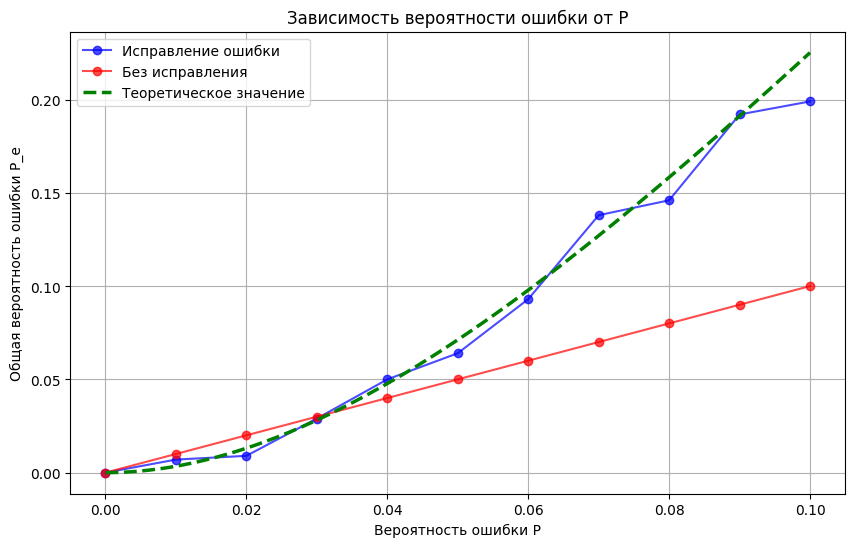

In [12]:
import concurrent.futures
import random
import sys, os
from zipfile import error
import time

import numpy as np
import matplotlib.pyplot as plt

from shors_9_cubit_code.constants import RX, CNOT_func, I, H, TOFFOLI, X, Z
from shors_9_cubit_code.symulator import NQubitSimulator


def shor9(P=0.05, debug=False):
    global pauli_x_error
    sim = NQubitSimulator(9) # 9 qub
    sim.apply_single_qubit_gate(RX(np.pi / 5), 0) # R к 0-му Pi/5
    inital_state = sim.get_qubit_state_raw(0) # сохраняем начальное => 1 логический 0 + 8 вспомогат.

    if debug:
        print('Initial system state:')
        for i in range(sim.dimension):
            print(f'State {i}: {sim.get_qubit_state(i)}')

    # Coding.
    # S1
    CNOT_03 = CNOT_func(9, 0, 3) # Кодирование состояния 0 в кубит 3
    sim.apply_n_qubit_gate(CNOT_03)

    # S2
    CNOT_06 = CNOT_func(9, 0, 6) # Кодирование состояния 0 в кубит 6
    sim.apply_n_qubit_gate(CNOT_06)
    # => тройка запутанных 0,3,6
    # S3
    sim.apply_n_gates(H, I, I, H, I, I, H, I, I) # Гейты адамара к 0,3,6 Z-> X что б убрать Z ошибки

    # S4
    CNOT_01 = CNOT_func(N=9, c=0, t=1) # Еще кодируем кубиты в 1 в 4 в 7 = (0,1,2)
    CNOT_34 = CNOT_func(N=9, c=3, t=4) # 3,4,5
    CNOT_67 = CNOT_func(N=9, c=6, t=7) # 6,7,8
    S4_operator = np.dot(np.dot(CNOT_01, CNOT_34), CNOT_67)
    sim.apply_n_qubit_gate(S4_operator)

    # S5
    CNOT_02 = CNOT_func(N=9, c=0, t=2)
    CNOT_35 = CNOT_func(N=9, c=3, t=5)
    CNOT_68 = CNOT_func(N=9, c=6, t=8)
    S5_operator = np.dot(np.dot(CNOT_02, CNOT_35), CNOT_68)
    sim.apply_n_qubit_gate(S5_operator)

    if debug:
        print('Finishing coding part:')
        for i in range(sim.dimension):
            print(f'State {i}: {sim.get_qubit_state(i)}')

    error_count = 0

    for idx in range(0, sim.dimension):
        if random.random() <= P: # с вероятностью P
            error_count += 1
            if error_count > 1:
                return False, error_count
            if debug:
                print(f'Error in {idx}')
                # sim.apply_single_qubit_gate(X, idx) # X-ошибка ЛИБО ПОСТОЯННО Х
            pauli_x_error = random.random() > 0.5
            if pauli_x_error:
                sim.apply_single_qubit_gate(X, idx) # X-ошибка
            else:
                sim.apply_single_qubit_gate(Z, idx) # Z-ошибка
    if debug:
        print('Finishing error simulation part:')
        for i in range(sim.dimension):
            print(f'State {i}: {sim.get_qubit_state(i)}')

        if error_count:
            print(f'{error_count} - P: {P}')
    # Decoding
    # S6 - clone of S4
    sim.apply_n_qubit_gate(S4_operator) # декод отменяет запутаность

    # S7 - clone of S5
    sim.apply_n_qubit_gate(S5_operator) # так же

    # S8
    TOFFOLI_120 = TOFFOLI(N=9, controls=[1, 2], target=0) # Тоффоли меняет целевой кубит если оба 1
    TOFFOLI_453 = TOFFOLI(N=9, controls=[4, 5], target=3)
    TOFFOLI_876 = TOFFOLI(N=9, controls=[8, 7], target=6)

    # Комбинируем все Toffoli-гейты в один оператор
    S8_operator = np.dot(np.dot(TOFFOLI_120, TOFFOLI_453), TOFFOLI_876)
    sim.apply_n_qubit_gate(S8_operator)

    # S9 - clone of S3
    sim.apply_n_gates(H, I, I, H, I, I, H, I, I)

    # S10 - clone of S1
    sim.apply_n_qubit_gate(CNOT_03)

    # S11 - clone of S2
    sim.apply_n_qubit_gate(CNOT_06)

    # S12
    TOFFOLI_360 = TOFFOLI(N=9, controls=[3, 6], target=0)
    sim.apply_n_qubit_gate(TOFFOLI_360)
    if debug:
        print('Finishing decoding part')
        for i in range(sim.dimension):
            print(f'State {i}: {sim.state[0]}')

    finite_state = sim.get_qubit_state_raw(0)
    if np.isclose(finite_state['|0>'], inital_state['|0>'], 0.01) and np.isclose(finite_state['|1>'],
                                                                                 inital_state['|1>'], 0.01):
        return (True, error_count)
    else:
        return (False, error_count)

def no_correction(P=0.05, debug=False):
    sim = NQubitSimulator(1)
    sim.apply_single_qubit_gate(RX(np.pi / 5), 0)
    inital_state = sim.get_qubit_state_raw(0)

   # ошибки
    error_count = 0
    if random.random() <= P:
        error_count += 1
        if debug:
            print(f'Error applied')
        sim.apply_single_qubit_gate(X, 0)

    # Check.
    finite_state = sim.get_qubit_state_raw(0)
    if np.isclose(finite_state['|0>'], inital_state['|0>'], 0.0001) and np.isclose(finite_state['|1>'],
                                                                                 inital_state['|1>'], 0.0001):
        return True, error_count
    else:
        return False, error_count

def compute_failure_probability(args):
    P, total_rounds = args

    # Если P == 0, то вероятность ошибки = 0
    if P == 0:
        return (P, 0, 0)

    failure_count = 0
    start_time = time.time()

    for i in range(total_rounds):
        correct = shor9(P=P)
        if not correct[0]:
            failure_count += 1

    p_e = failure_count / total_rounds
    p_e_nc = P
    print(f'finished P={P}. Spent time: {time.time() - start_time}')
    return (P, p_e, p_e_nc)

def parallel_compute_failure_probability(p_values, total_rounds=500):
    results = []

    args_list = [(p, total_rounds) for p in p_values]

    with concurrent.futures.ThreadPoolExecutor(max_workers=min(4, len(p_values))) as executor:
        # Map ожидает функцию, принимающую один аргумент - кортеж
        results = list(executor.map(compute_failure_probability, args_list))

    return results

def theory(p):
    return 1 - (1 + 8 * p) * (1 - p) ** 8

def shor9_withplot():
    p = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] # вероятности ошибок
    p_e = [] # c
    p_e_nc = [] # без
    total_rounds = 1000 # slow

    results = parallel_compute_failure_probability(p, total_rounds)

    for result in results:
        P, p_e_value, p_e_nc_value = result
        p_e.append(p_e_value)
        p_e_nc.append(p_e_nc_value)
        print(f'finished {P} with P_e: {p_e_value} || P_e_nc: {p_e_nc_value}')

    plt.figure(figsize=(10, 6))
    plt.plot(p, p_e, marker='o', label='Исправление ошибки', linestyle='-', color='b', alpha=0.7)
    plt.plot(p, p_e_nc, label='Без исправления', marker='o', linestyle='-', color='r', alpha=0.7)

    p_values = np.linspace(0, max(p), 100)
    theory_values = theory(p_values)

    plt.plot(p_values, theory_values, label='Теоретическое значение', color='green', linestyle='--', linewidth=2.5)
    plt.xlabel('Вероятность ошибки P')
    plt.ylabel('Общая вероятность ошибки P_e')
    plt.title('Зависимость вероятности ошибки от P')
    plt.grid(True)
    plt.legend()
    plt.show()

shor9_withplot()